In [ ]:
import roc3
from roc3.weather import *
from importlib import reload
from roc3.rfp import *
from roc3.apm import *
from roc3.bada4 import *
from roc3.accf import *
import roc3
import roc3.pipeliness
import pickle
import yaml


def create_path_not_exist (path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
    return path    

lib_directory = '/Users/abolfazlsimorgh/Downloads/roc/'


path_ = lib_directory + 'test/results/'
create_path_not_exist (path_)
path_save = path_ + 'trj_EI{}.json'




Airport_lat_lon = {}
Airport_lat_lon ['Manchester'] = (53.3554, -2.2773)
Airport_lat_lon ['Marseille'] = (43.4384, 5.2144)
Airport_lat_lon ['Lisbon'] = (38.7756, -9.1354)
Airport_lat_lon ['Zagreb'] = (45.7408, 16.0674)
Airport_lat_lon ['Venice'] = (45.5047, 12.3466)
Airport_lat_lon ['Stockholm'] = (59.0, 17.9238)
Airport_lat_lon ['Istanbul'] = (41.2768, 28.7300)
Airport_lat_lon ['Brugge'] = (51.2044, 2.8699)
Airport_lat_lon ['Minsk'] = (53.8897, 28.0342)
Airport_lat_lon['Frankfurt'] = (50.0379, 8.5622)
Airport_lat_lon['Kiev'] = (50.3382, 30.8939)


with open('/Users/abolfazlsimorgh/data_20dec2018_r_10member_aCCFs_day_olr.pickle', 'rb') as handle:
    wm = pickle.load(handle)  

apm = BADA4_jet_CR('A320-214', full_path= lib_directory + 'test/data/A320-214.xml')

problem_setup = {
    'destination': Airport_lat_lon ['Kiev'], 
    'origin':  Airport_lat_lon ['Frankfurt'], 
    'h0': H2h(5000), 
    'hf': H2h(5000), 
    'CI': 1.0,
    'C_m': 0.51,
    'DP': 0.0,
    'm0': 61600,#apm.MTOW*0.8,
    't0': 1526190000.0 + 0,
    'tas0': 150,
    'tasf': 150,
    'mfb':0,
    'lagr_2d': lambda *x: 0,
    'CP': 0.0,
    'ac_code': 'A330-341',
    'altitude': 'track',
    'airspeed': 'variable',
    'tas_slope_regularization': 1e3,
    'h_slope_regularization': 2.0,
    'clim_ig': False,
    'climate_impact': True,
    'EI': 0.0
    }



""" %%%%%%%%%%%%%%%%% LOAD CONFIGURATIONS %%%%%%%%%%%%%%%% """

with open(lib_directory + "config-user.yml", "r") as ymlfile:
    confg = yaml.safe_load(ymlfile)

problem_setup.update (confg)   

# list including weights of average climate impact in the cost functional
EI = [500.0]

# weights of cost CI * (0.75 * time + C_m * fuel)
problem_setup['CI'] = 1.0

# weights of fuel consumption
problem_setup['C_m'] = 0.51

for indx, alp in enumerate (EI):

    problem_setup['EI'] = EI[indx]

    p1 = roc3.pipeliness.Routing2DStandard(apm, wm.get_slice_with_n_member(10), problem_setup, 80, solver_options={'linear_solver':'mumps'})
    trj = p1.solve(stop=False)

    with open(path_save.format(alp), 'w') as f:
        trj.save_to_json(f)   



In [6]:
# path = '/Users/abolfazlsimorgh/Documents/My_New_studies/ROC_last_V/roc3_aCCF/Test_more_scenario/data_27june_r_aCCFs_day_olr.nc'
# ws = WeatherStore_4D(path)
# ws.reduce_domain({'lat': (40, 55), 'lon': (-4, 7.0)})
# wm = ws.get_weather_model(10)
# with open('test/data/data_june27.pickle', 'wb') as handle:
#     pickle.dump(wm, handle, protocol=pickle.HIGHEST_PROTOCOL)    

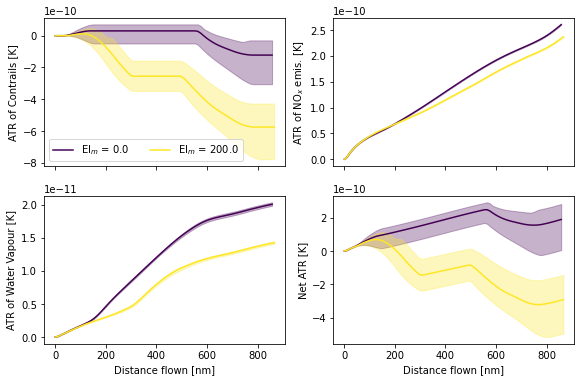

In [34]:
import matplotlib as mpl
from scipy import integrate
from roc3.accf import *

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9.5,6), sharex=True)
font = {'family' : 'normal',
        'size'   : 11}

path = 'test/results/trj_EI{}.json'

# Ensemble members
N = 10

EI = [0.0, 200.0]
alpha = EI

cmap_dp = mpl.cm.viridis
norm_dp = mpl.colors.Normalize(vmin=0, vmax=float(len(alpha))-1)
col = []
for i in range (0, len(alpha)):
    col.append (cmap_dp(norm_dp(float(i))))

ATR = np.zeros ((N,len(alpha)))
SOC = np.zeros ((N,len(alpha)))
SOC_t = np.zeros ((N,len(alpha)))

dict_trjs = {}

for i, alp in enumerate(alpha):
  with open(path.format(alp), 'r') as f:          
      dict_trjs[alp] = trj = DiscreteTrajectory.load_from_json(f)
  
  ## calculate pl from recieved altitude:
  P = np.zeros(np.shape(trj.x['h']))
  for kk in range (0,len(trj.x['h'])):
    P[kk] = Hp2P(h2H(trj.x['h'][kk]))

  ATR_cont = np.zeros ((N,len(trj.x['h'])))  
  ATR_H2O  = np.zeros ((N,len(trj.x['h'])))  
  ATR_NOx  = np.zeros ((N,len(trj.x['h'])))  
  ATR_CO2  = np.zeros ((N,len(trj.x['h'])))  
  ATR_net  = np.zeros ((N,len(trj.x['h']))) 

  time = np.zeros (N)
  mass = np.zeros (N)

  distance_flown =  np.array(trj.t)
  distance_flown_u =  np.array(trj.tu)

  ds = np.zeros (len(trj.x['h']))
  for j in range(N):
    time[j] = trj.x[f't_{j}'][-1] - trj.x[f't_{j}'][0]
    mass[j] = trj.x[f'm_{j}'][0] - trj.x[f'm_{j}'][-1]

    for k in range(1,len(trj.x.lat)):
      ds[k] = distance_flown[k] - distance_flown[k-1]

      olr = wm[j].olr(trj.x['lat'][k], trj.x['lon'][k], P[k], np.array(trj.x[f't_{j}'][k]))
      temp = wm[j].T(trj.x['lat'][k], trj.x['lon'][k], P[k], np.array(trj.x[f't_{j}'][k]))
      rel_ice = wm[j].r(trj.x['lat'][k], trj.x['lon'][k], P[k], np.array(trj.x[f't_{j}'][k]))*100
      aCCF_NOx = wm[j].aCCF_NOx(trj.x['lat'][k], trj.x['lon'][k], P[k], np.array(trj.x[f't_{j}'][k]))
      aCCF_H2O = wm[j].aCCF_H2O(trj.x['lat'][k], trj.x['lon'][k], P[k], np.array(trj.x[f't_{j}'][k]))

      if rel_ice > confg['r_thr'] and temp < confg['t_thr']:
        pcfa = 1
      else: 
        pcfa = 0  

      ATR_cont[j,k] = 1e-3 * (confg['daytime'] * aCCF_dCont (olr) + confg['nighttime'] * aCCF_nCont (temp))  * pcfa
      ATR_H2O [j,k] = aCCF_H2O * -(trj.x[f'm_{j}'][k] - trj.x[f'm_{j}'][k-1])/ds[k]
      ATR_NOx [j,k] = 0.015 * aCCF_NOx * -(trj.x[f'm_{j}'][k] - trj.x[f'm_{j}'][k-1])/ds[k]
      ATR_CO2 [j,k] = 10.1 * 6.94e-16 * -(trj.x[f'm_{j}'][k] - trj.x[f'm_{j}'][k-1])/ds[k]

      

    ATR_cont[j,1::] = integrate.cumtrapz(ATR_cont[j,:], distance_flown)
    ATR_H2O[j,1::] = integrate.cumtrapz(ATR_H2O[j,:], distance_flown)
    ATR_NOx[j,1::] = integrate.cumtrapz(ATR_NOx[j,:], distance_flown)
    ATR_CO2[j,1::] = integrate.cumtrapz(ATR_CO2[j,:], distance_flown)
    ATR_net[j,1::] =  ATR_NOx[j,1::] + ATR_H2O[j,1::] + ATR_cont[j,1::] + ATR_CO2[j,1::] 

  tas_slope = np.zeros(distance_flown.shape)
  h_slope = np.zeros(distance_flown.shape)

  SOC_tas = np.ones(N)*problem_setup['tas_slope_regularization']*(integrate.cumtrapz(np.array(trj.u['tas_slope'])**2,distance_flown_u)[-1])
  SOC_h = np.ones(N)*problem_setup['h_slope_regularization']*(integrate.cumtrapz(np.array(trj.u['h_slope'])**2,distance_flown_u)[-1])
  SOC[:,i] = 0.75 * time + 0.51 * mass #+ SOC_tas + SOC_h
  SOC_t [:,i] = SOC[:,i] +  1e10 * ATR_net [:,-1]
  ATR[:,i] = ATR_net [:,-1]
  
  ax = axes[0,0]

  ax.plot(distance_flown*0.539957/1000, np.mean(ATR_cont,axis = 0), label = 'EI$_m$ = {}'.format(alpha[i]) , color = col[i])   
  ax.fill_between(distance_flown*0.539957/1000, np.min(ATR_cont,axis = 0), np.max(ATR_cont,axis = 0), color = col[i], alpha=0.3) 
  ax.set_ylabel("ATR of Contrails [K]")
  ax.legend(ncol = 2)



  ax = axes[0,1]
  ax.plot(distance_flown*0.539957/1000, np.mean(ATR_NOx,axis = 0), color = col[i])    
  ax.fill_between(distance_flown*0.539957/1000, np.min(ATR_NOx,axis = 0), np.max(ATR_NOx,axis = 0), color = col[i], alpha=0.3) 
  ax.set_ylabel("ATR of NO$_{x}$ emis. [K]")

  

  ax = axes[1,0]
  ax.plot(distance_flown*0.539957/1000, np.mean(ATR_H2O,axis = 0), color = col[i])    
  ax.fill_between(distance_flown*0.539957/1000, np.min(ATR_H2O,axis = 0), np.max(ATR_H2O,axis = 0), color = col[i], alpha=0.3) 
  ax.set_ylabel("ATR of Water Vapour [K]")
  ax.set_xlabel("Distance flown [nm]")

  ax = axes[1,1]
  ax.plot(distance_flown*0.539957/1000, np.mean(ATR_net,axis = 0), color = col[i])    
  ax.fill_between(distance_flown*0.539957/1000, np.min(ATR_net,axis = 0), np.max(ATR_net,axis = 0), color = col[i], alpha=0.3) 
  ax.set_ylabel("Net ATR [K]")
  ax.set_xlabel("Distance flown [nm]")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


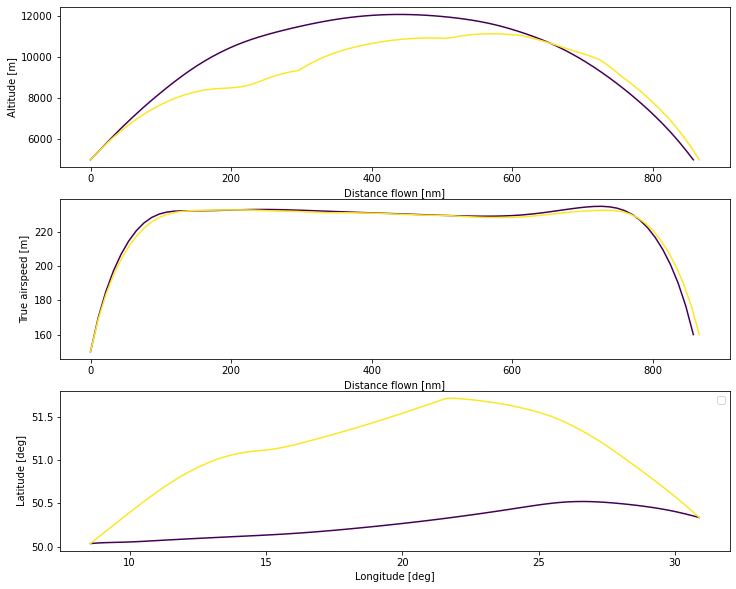

In [35]:
import matplotlib as mpl


plt.rcParams['figure.figsize'] = (12,10)
ax = []


fig, axes = plt.subplots(3,1, sharex=False)
for i, alp in enumerate(alpha):
    CI = alp

    trj = dict_trjs[alp]    
    ax = axes[0]
    axes[0].set_ylabel("Altitude [m]")
    axes[0].set_xlabel("Distance flown [nm]")
    ax.plot(np.array(trj.t)*0.539957/1000,trj.x['h'],color=col[i], label = 'EI$_m$ = {}'.format(alpha[i]))    
    
    
    ax = axes[1]
    axes[1].set_ylabel("True airspeed [m]")
    axes[1].set_xlabel("Distance flown [nm]")
    ax.plot(np.array(trj.t)*0.539957/1000,trj.x['tas'],color=col[i] ,label = 'EI$_m$ = {}'.format(alpha[i]))    
    
    
    ax = axes[2]
    axes[2].set_ylabel("Latitude [deg]")
    axes[2].set_xlabel("Longitude [deg]")
    ax.plot(trj.x['lon'],trj.x['lat'],color=col[i])    

    
    ax.legend()

plt.show()
            